In [1]:
!git clone https://github.com/LEDgEr67/Self-Driving-Car.git
!ls Self-Driving-Car
!pip3 install imgaug
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Cloning into 'Self-Driving-Car'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 23728 (delta 0), reused 0 (delta 0), pack-reused 23727
Receiving objects: 100% (23728/23728), 304.86 MiB | 34.05 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (11890/11890), done.
driving_log.csv  IMG


In [2]:
datadir = 'Self-Driving-Car'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,D:\Projects\Self Driving Car\DataSets\IMG\center_2021_03_23_22_22_35_982.jpg,D:\Projects\Self Driving Car\DataSets\IMG\left_2021_03_23_22_22_35_982.jpg,D:\Projects\Self Driving Car\DataSets\IMG\right_2021_03_23_22_22_35_982.jpg,0.0,0.00000,0,0.000010
1,D:\Projects\Self Driving Car\DataSets\IMG\center_2021_03_23_22_22_35_998.jpg,D:\Projects\Self Driving Car\DataSets\IMG\left_2021_03_23_22_22_35_998.jpg,D:\Projects\Self Driving Car\DataSets\IMG\right_2021_03_23_22_22_35_998.jpg,0.0,0.00000,0,0.000012
2,D:\Projects\Self Driving Car\DataSets\IMG\center_2021_03_23_22_22_36_064.jpg,D:\Projects\Self Driving Car\DataSets\IMG\left_2021_03_23_22_22_36_064.jpg,D:\Projects\Self Driving Car\DataSets\IMG\right_2021_03_23_22_22_36_064.jpg,0.0,0.00000,0,0.000011
3,D:\Projects\Self Driving Car\DataSets\IMG\center_2021_03_23_22_22_36_134.jpg,D:\Projects\Self Driving Car\DataSets\IMG\left_2021_03_23_22_22_36_134.jpg,D:\Projects\Self Driving Car\DataSets\IMG\right_2021_03_23_22_22_36_134.jpg,0.0,0.12298,0,0.031571
4,D:\Projects\Self Driving Car\DataSets\IMG\center_2021_03_23_22_22_36_202.jpg,D:\Projects\Self Driving Car\DataSets\IMG\left_2021_03_23_22_22_36_202.jpg,D:\Projects\Self Driving Car\DataSets\IMG\right_2021_03_23_22_22_36_202.jpg,0.0,0.30349,0,0.195918


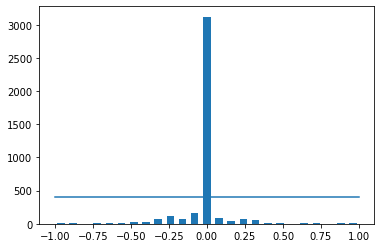

In [3]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 3963
removed: 2720
remaining: 1243


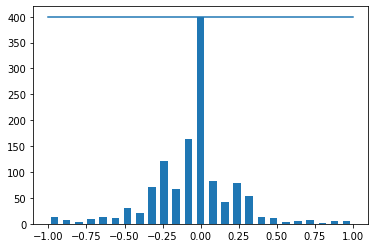

In [4]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [5]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2021_03_23_22_22_36_749.jpg
left        left_2021_03_23_22_22_36_749.jpg  
right       right_2021_03_23_22_22_36_749.jpg 
steering   -0.35                              
throttle    1                                 
reverse     0                                 
speed       5.84389                           
Name: 12, dtype: object


In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 2983
Valid Samples: 746


Text(0.5, 1.0, 'Validation set')

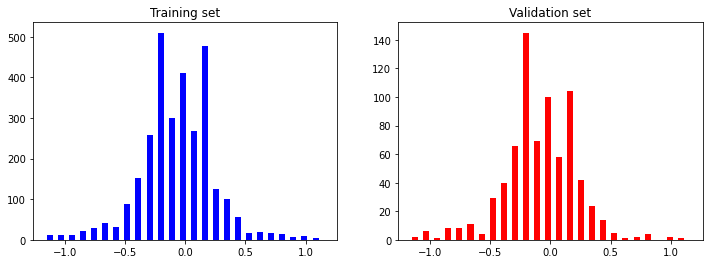

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Text(0.5, 1.0, 'Zoomed Image')

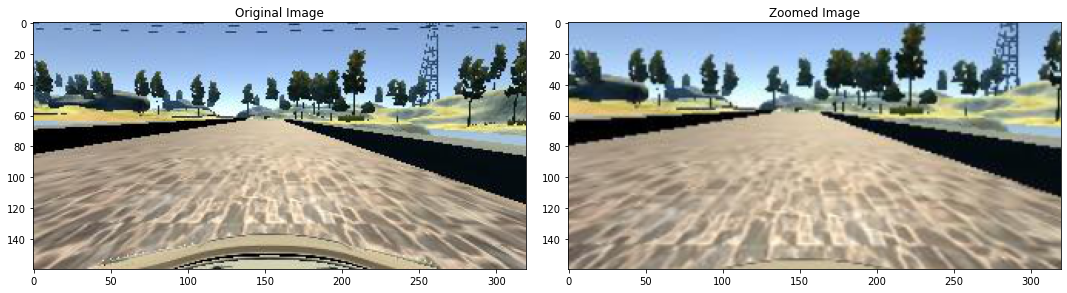

In [8]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [9]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

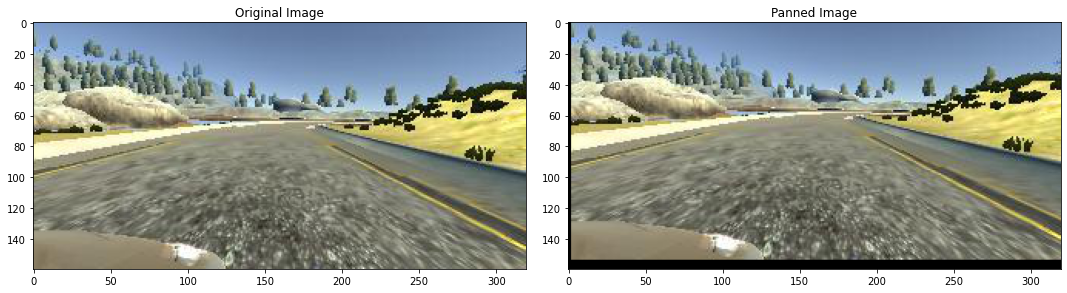

In [10]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [11]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'Brightness altered image ')

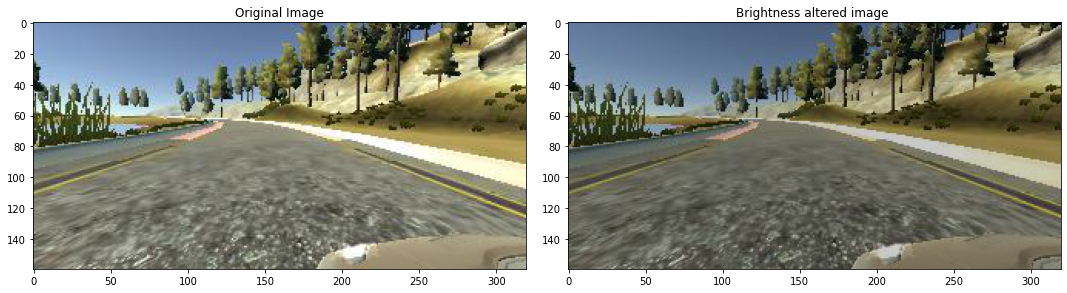

In [12]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.2')

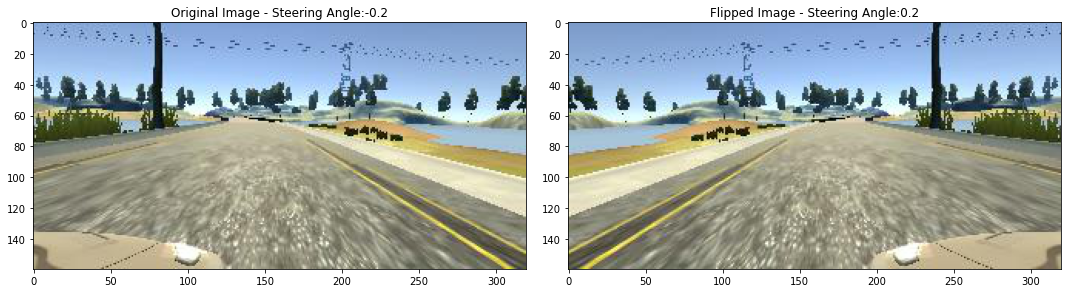

In [13]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [14]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

In [15]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

Output hidden; open in https://colab.research.google.com to view.

Text(0.5, 1.0, 'Preprocessed Image')

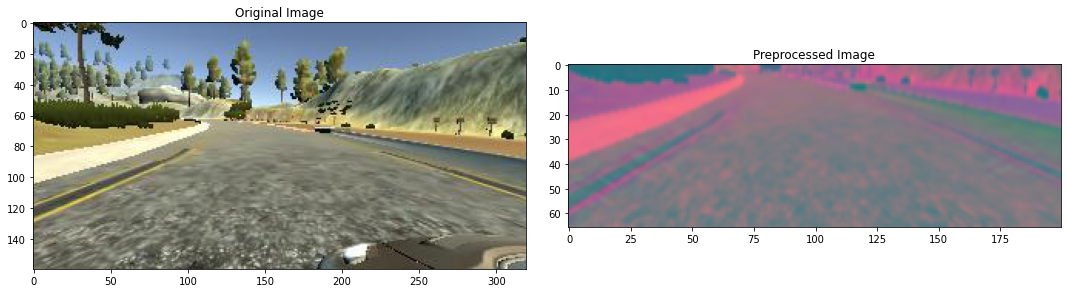

In [16]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [17]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  

Text(0.5, 1.0, 'Validation Image')

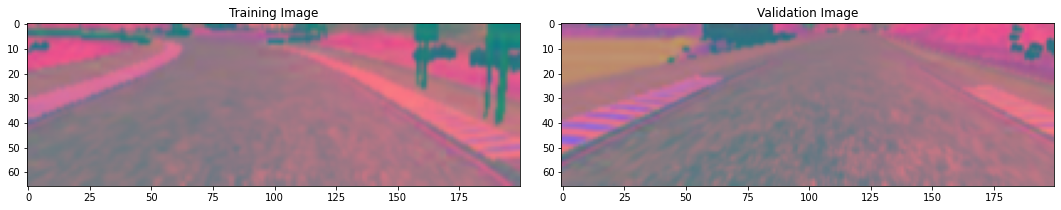

In [18]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [19]:
def nvidia_model():
 
  model = Sequential()
  
  model.add(Convolution2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='relu'))
  
  model.add(Convolution2D(36, kernel_size=(5,5), strides=(2,2), activation='relu'))
  model.add(Convolution2D(48, kernel_size=(5,5), strides=(2,2), activation='relu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='relu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='relu'))
  model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dropout(0.5))
  
  
  model.add(Dense(50, activation='relu'))
  model.add(Dense(10, activation ='relu'))
  model.add(Dense(1))
  
  
  optimizer= Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  
  return model

In [20]:
model = nvidia_model()
print(model.summary())
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
300/300 [==============================] - 420s 1s/step - loss: 0.0811 - val_loss: 0.0546
Epoch 2/10
300/300 [==============================] - 416s 1s/step - loss: 0.0580 - val_loss: 0.0467
Epoch 3/10
300/300 [==============================] - 416s 1s/step - loss: 0.0543 - val_loss: 0.0440
Epoch 4/10
300/300 [==============================] - 418s 1s/step - loss: 0.0527 - val_loss: 0.0463
Epoch 5/10
300/300 [==============================] - 419s 1s/step - loss: 0.0506 - val_loss: 0.0399
Epoch 6/10
300/300 [==============================] - 420s 1s/step - loss: 0.0477 - val_loss: 0.0385
Epoch 7/10
300/300 [==============================] - 418s 1s/step - loss: 0.0465 - val_loss: 0.0366
Epoch 8/10
300/300 [==============================] - 415s 1s/step - loss: 0.0437 - val_loss: 0.0374
Epoch 9/10
300/300 [==============================] - 416s 1s/step - loss: 0.0422 - val_loss: 0.0337
Epoch 10/10
300/300 [==============================] - 418s 1s/step - loss: 0.0408 - val_lo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

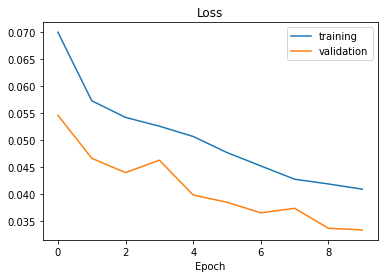

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
model.save('model.h5')
from google.colab import files
files.download('model.h5')